In [25]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg
import os
import json

# load demand data
# DATA_NAME = 'ndf50_mldat6e8_university'
DATA_NAME = 'university_k_4_L_2_n_4_chancap500_numchans1_mldat2e6_bidirectional'
path_to_benchmark_data = '/scratch/datasets/trafpy/traces/flowcentric/{}_benchmark_data.json'.format(DATA_NAME)
benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time to load data from /scratch/datasets/trafpy/traces/flowcentric/university_k_4_L_2_n_4_chancap500_numchans1_mldat2e6_bidirectional_benchmark_data.json: 1.1418743133544922 s


In [26]:
%autoreload

# organise into list of demand_data dicts
benchmarks = list(benchmark_data.keys())
demand_data_list = []
loads = []
for benchmark in benchmarks:
    for load in benchmark_data[benchmark]:
        for repeat in benchmark_data[benchmark][load]:
            demand_data = benchmark_data[benchmark][load][repeat]
            demand_data_list.append(demand_data)
            loads.append(load)
num_sets_of_demand_data = len(demand_data_list)
print('Number of sets of demand data: {}'.format(num_sets_of_demand_data))
# print(demand_data_list[0])

Number of sets of demand data: 5


In [27]:
# COMPUTE METRICS (NO PLOTTING -> FASTER)

%autoreload
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # disable warnings
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter, DemandsPlotter

# for plotting
net = tpg.gen_fat_tree(k=4, L=2, n=4, num_channels=1, server_to_rack_channel_capacity=500, rack_to_edge_channel_capacity=1000, edge_to_agg_channel_capacity=1000, agg_to_core_channel_capacity=2000, bidirectional_links=True)
slot_size = 1e6

# create demand objects and print analysis summary
demands = []
for demand_data, load in zip(demand_data_list, loads):
    demand = Demand(demand_data, net.graph['endpoints'])
    demands.append(demand)
analyser = DemandsAnalyser(*demands)
analyser.compute_metrics(print_summary=True)

+----+--------+---------+-------+-------------+-------------+-------------+--------+------------+-------------+
|    | Name   |   Flows |   1st |        Last |    Duration |        Info |   Load |   Smallest |     Largest |
|----+--------+---------+-------+-------------+-------------+-------------+--------+------------+-------------|
|  0 | demand |  154471 |     0 | 9.6317e+06  | 9.6317e+06  | 3.85268e+09 |    400 |          1 | 5.45288e+07 |
|  1 | demand |  169918 |     0 | 5.45331e+06 | 5.45331e+06 | 4.36265e+09 |    800 |          1 | 5.45288e+07 |
|  2 | demand |  154471 |     0 | 3.12686e+06 | 3.12686e+06 | 3.75223e+09 |   1200 |          1 | 5.45288e+07 |
|  3 | demand |  169918 |     0 | 2.61947e+06 | 2.61947e+06 | 4.19115e+09 |   1600 |          1 | 5.45288e+07 |
|  4 | demand |  308942 |     0 | 3.96665e+06 | 3.96665e+06 | 7.9333e+09  |   2000 |          1 | 5.45288e+07 |
+----+--------+---------+-------+-------------+-------------+-------------+--------+------------+-------

+----+--------+---------+-------+-------------+-------------+-------------+--------+------------+-------------+
|    | Name   |   Flows |   1st |        Last |    Duration |        Info |   Load |   Smallest |     Largest |
|----+--------+---------+-------+-------------+-------------+-------------+--------+------------+-------------|
|  0 | demand |  154471 |     0 | 9.6317e+06  | 9.6317e+06  | 3.85268e+09 |    400 |          1 | 5.45288e+07 |
|  1 | demand |  169918 |     0 | 5.45331e+06 | 5.45331e+06 | 4.36265e+09 |    800 |          1 | 5.45288e+07 |
|  2 | demand |  154471 |     0 | 3.12686e+06 | 3.12686e+06 | 3.75223e+09 |   1200 |          1 | 5.45288e+07 |
|  3 | demand |  169918 |     0 | 2.61947e+06 | 2.61947e+06 | 4.19115e+09 |   1600 |          1 | 5.45288e+07 |
|  4 | demand |  308942 |     0 | 3.96665e+06 | 3.96665e+06 | 7.9333e+09  |   2000 |          1 | 5.45288e+07 |
+----+--------+---------+-------+-------------+-------------+-------------+--------+------------+-------

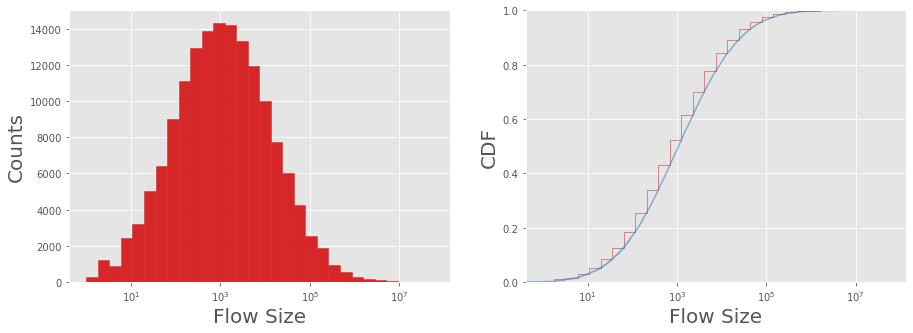

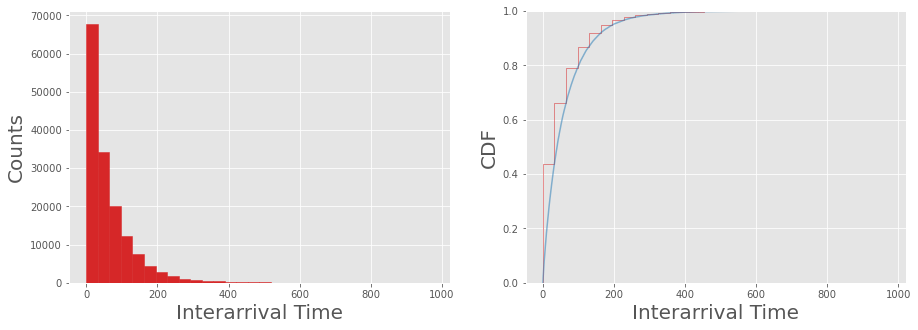

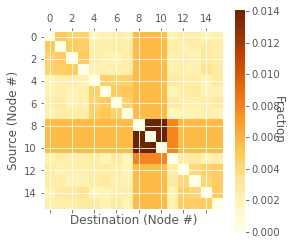

<Figure size 432x288 with 0 Axes>

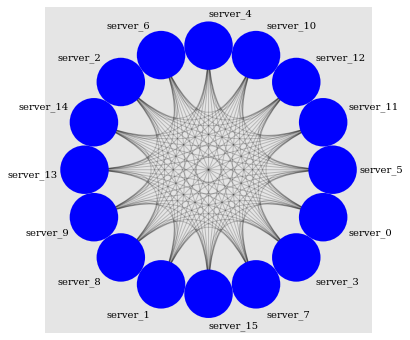

<Figure size 432x288 with 0 Axes>

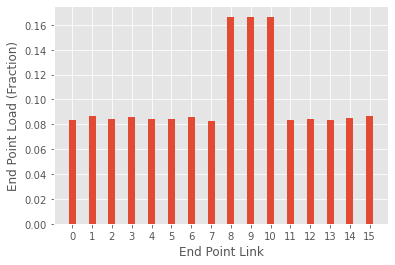

<Figure size 432x288 with 0 Axes>

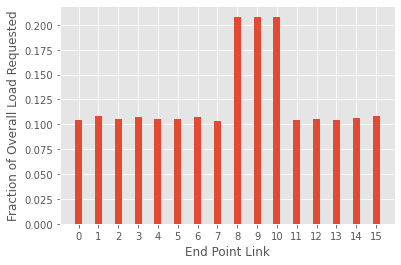

<Figure size 432x288 with 0 Axes>

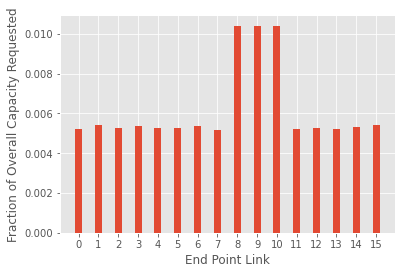

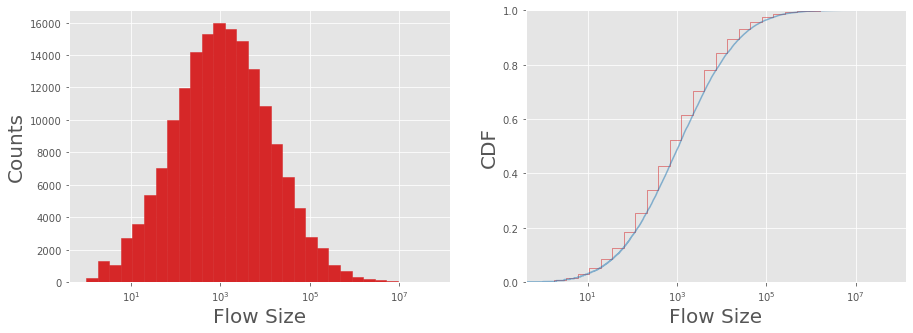

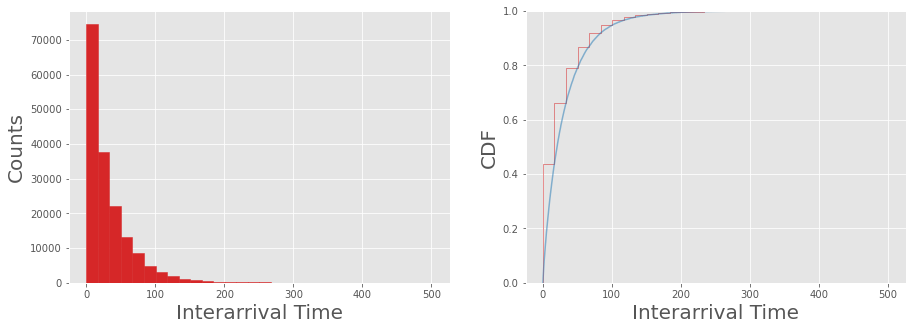

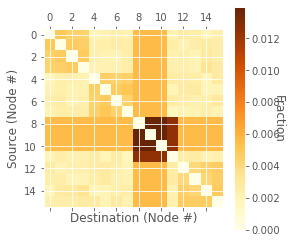

<Figure size 432x288 with 0 Axes>

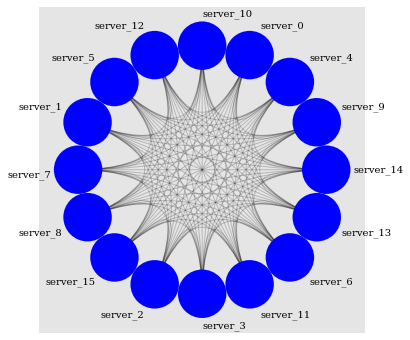

<Figure size 432x288 with 0 Axes>

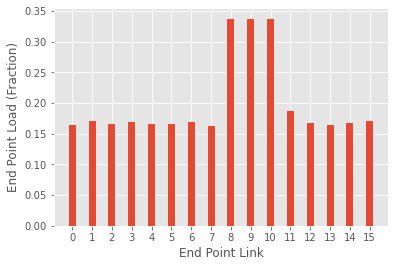

<Figure size 432x288 with 0 Axes>

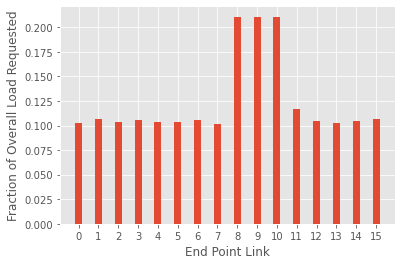

<Figure size 432x288 with 0 Axes>

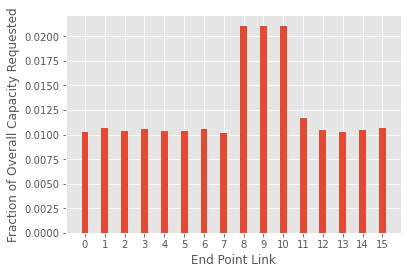

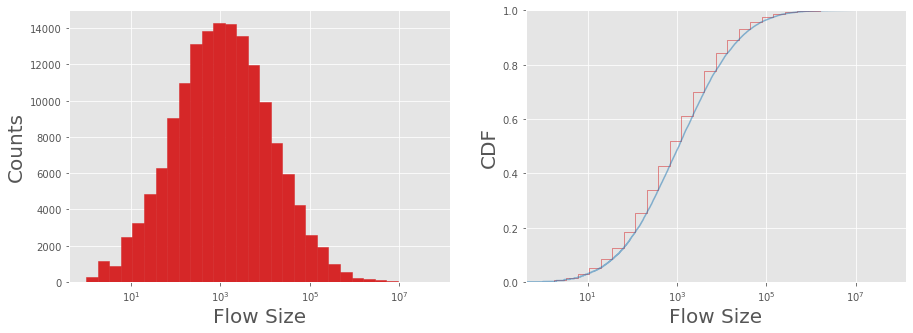

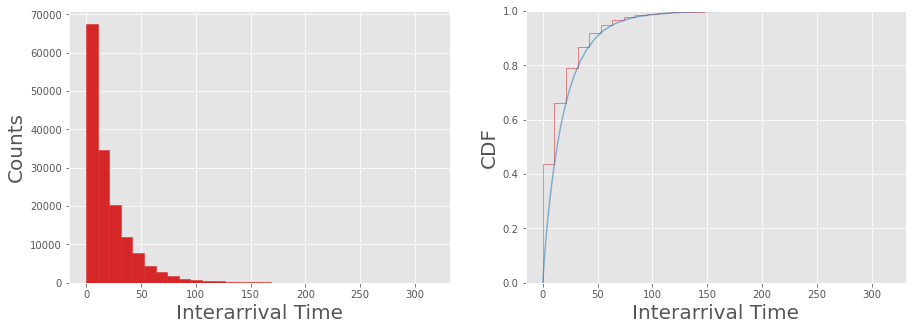

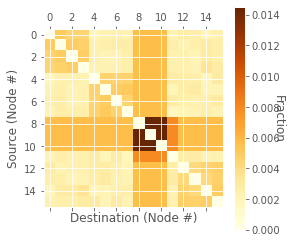

<Figure size 432x288 with 0 Axes>

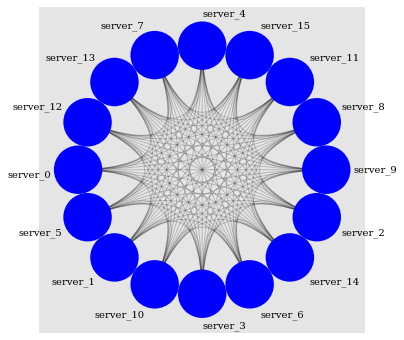

<Figure size 432x288 with 0 Axes>

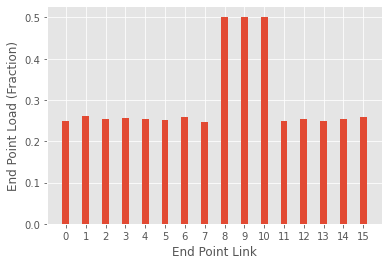

<Figure size 432x288 with 0 Axes>

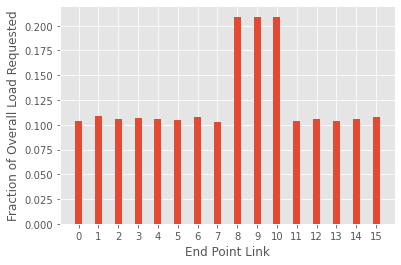

<Figure size 432x288 with 0 Axes>

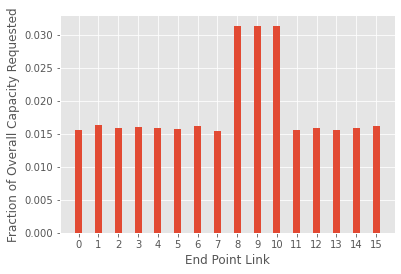

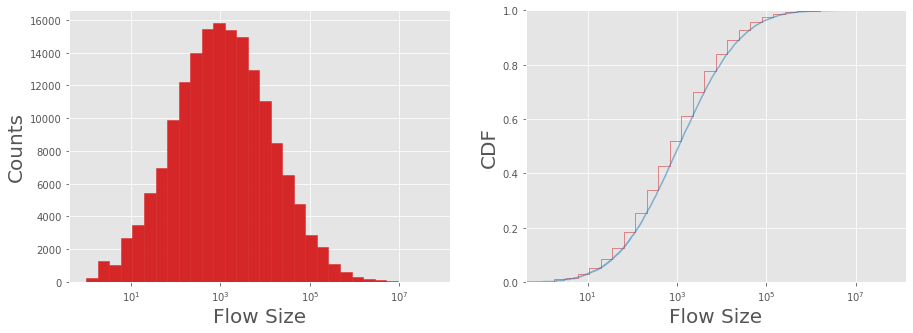

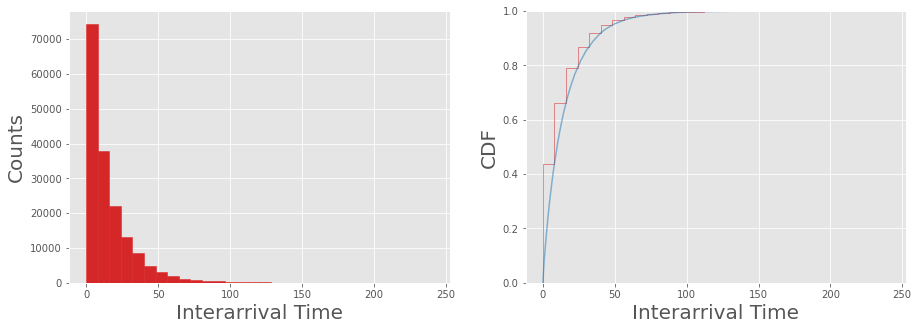

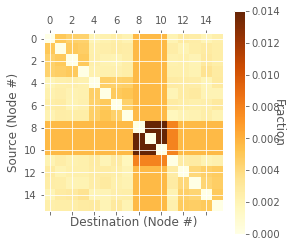

<Figure size 432x288 with 0 Axes>

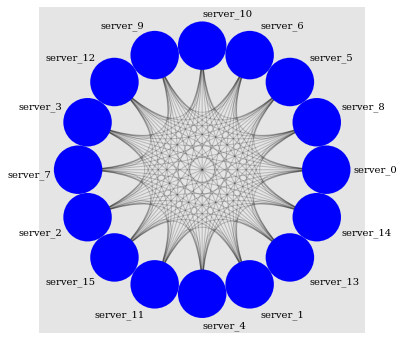

<Figure size 432x288 with 0 Axes>

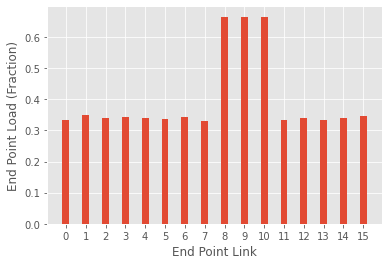

<Figure size 432x288 with 0 Axes>

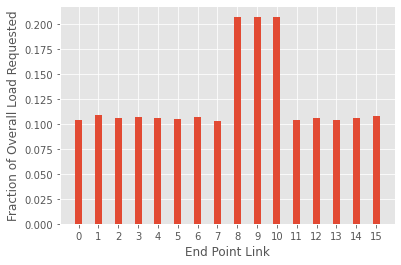

<Figure size 432x288 with 0 Axes>

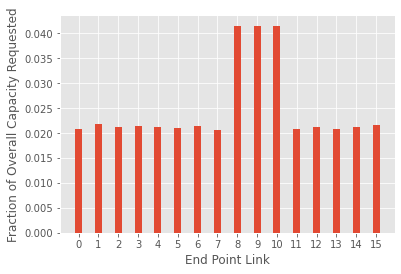

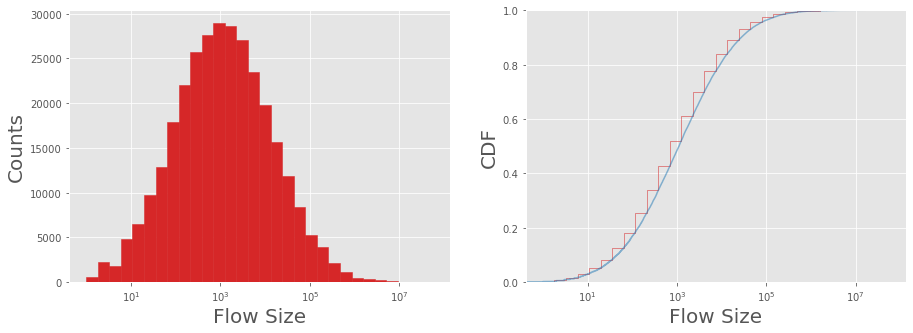

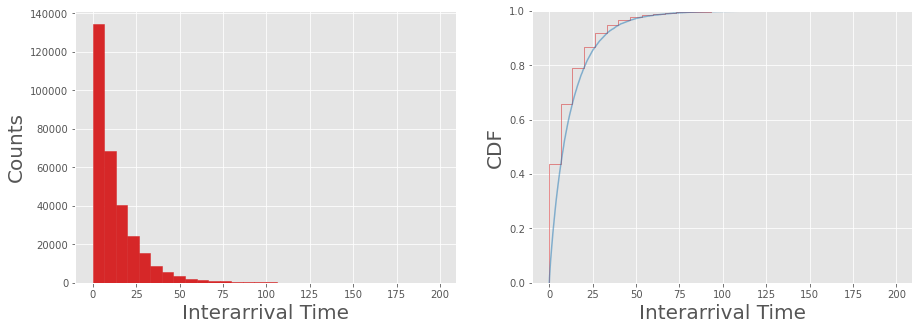

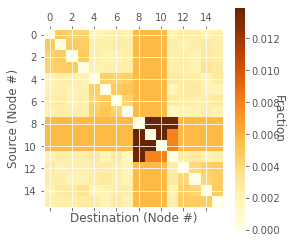

<Figure size 432x288 with 0 Axes>

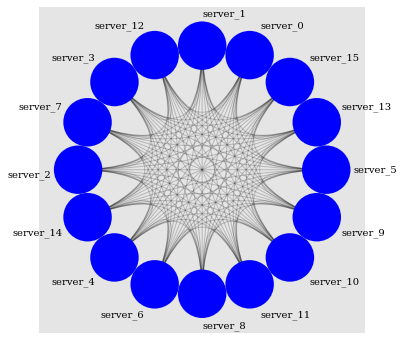

<Figure size 432x288 with 0 Axes>

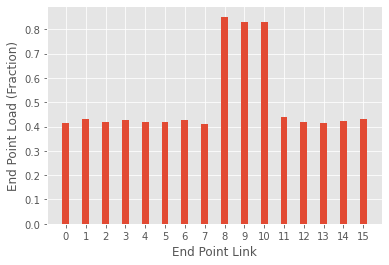

<Figure size 432x288 with 0 Axes>

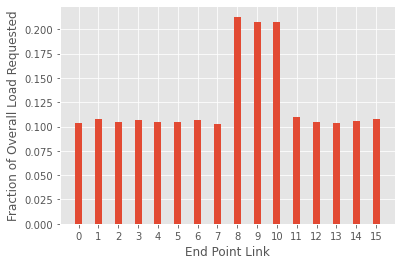

<Figure size 432x288 with 0 Axes>

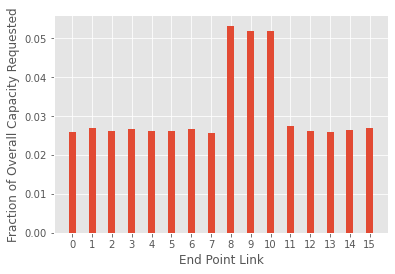

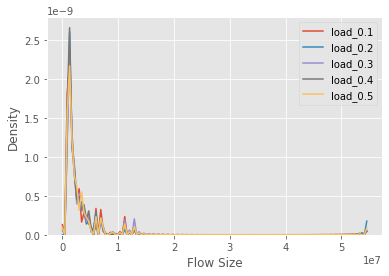

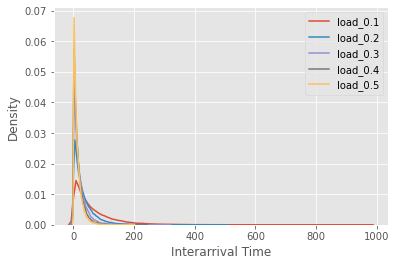

In [28]:
# COMPUTE METRICS AND PLOTTING

%autoreload
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # disable warnings
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter, DemandsPlotter

# for plotting
net = tpg.gen_fat_tree(k=4, L=2, n=4, num_channels=1, server_to_rack_channel_capacity=500, rack_to_edge_channel_capacity=1000, edge_to_agg_channel_capacity=1000, agg_to_core_channel_capacity=2000, bidirectional_links=True)
slot_size = 1e6

# create demand objects and print analysis summary
demands = []
for demand_data, load in zip(demand_data_list, loads):
    demand = Demand(demand_data, net.graph['endpoints'])
    demand.name = 'load_{}'.format(load) # name for multi-plot legend(s)
    demands.append(demand)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, num_bins=30)
    plotter.plot_interarrival_time_dist(logscale=False, num_bins=30)
    plotter.plot_node_dist(eps=net.graph['endpoints'])
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], ep_link_bandwidth=net.graph['ep_link_capacity'])
#     plotter.plot_node_load_dists(eps=net.graph['endpoints'], ep_link_bandwidth=500)
#     plotter.plot_link_loads_vs_time(net, slot_size, demand, mean_period='all')
analyser = DemandsAnalyser(*demands)
analyser.compute_metrics(print_summary=True)

plotters = DemandsPlotter(*demands)
_ = plotters.plot_flow_size_dists(logscale=False)
_ = plotters.plot_interarrival_time_dists(logscale=False)

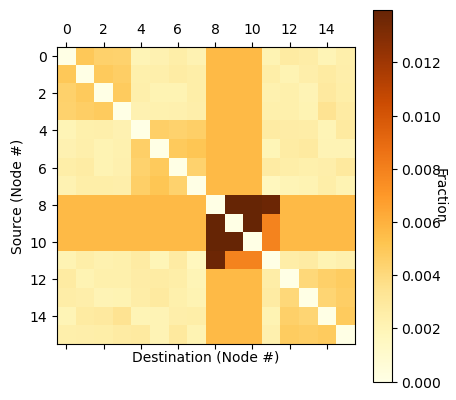

<Figure size 640x480 with 0 Axes>

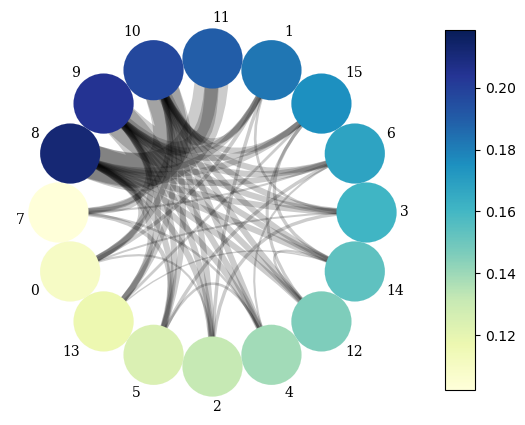

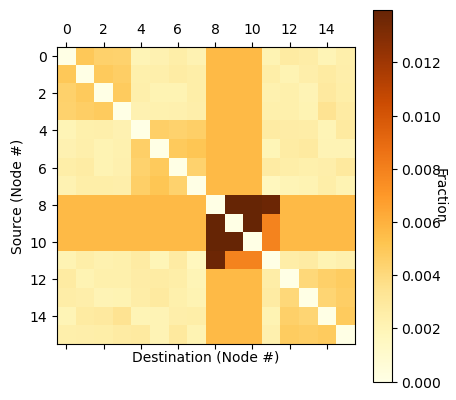

<Figure size 640x480 with 0 Axes>

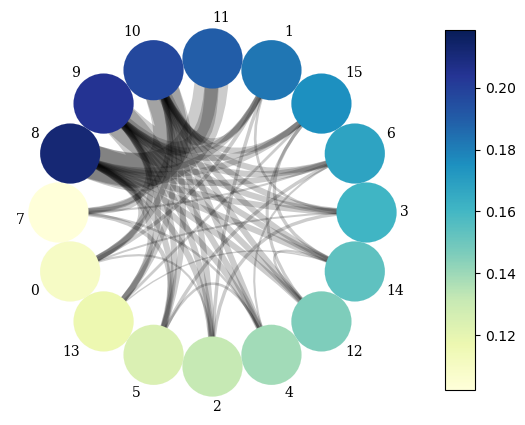

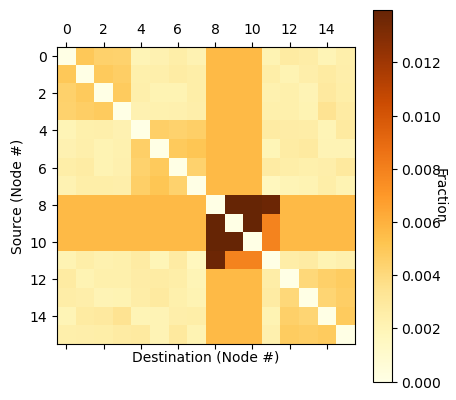

<Figure size 640x480 with 0 Axes>

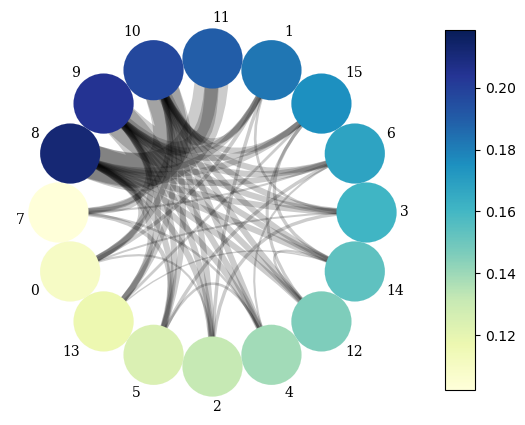

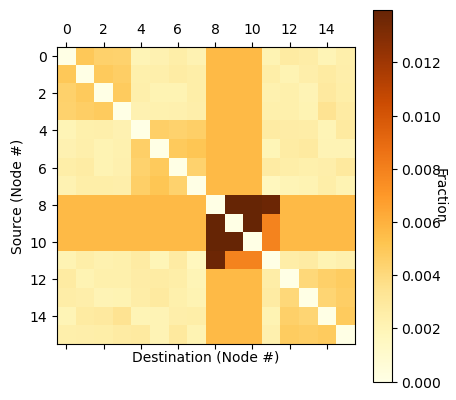

<Figure size 640x480 with 0 Axes>

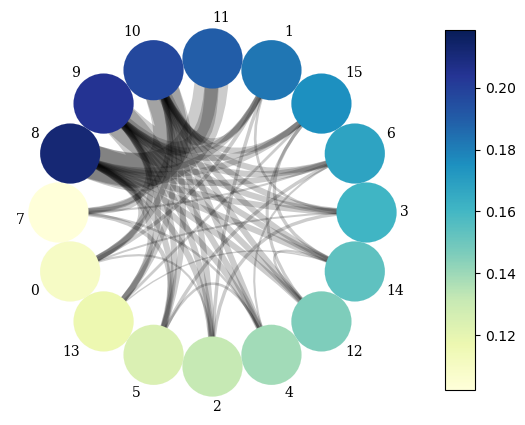

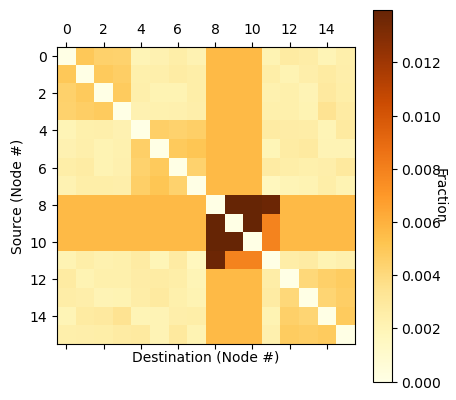

<Figure size 640x480 with 0 Axes>

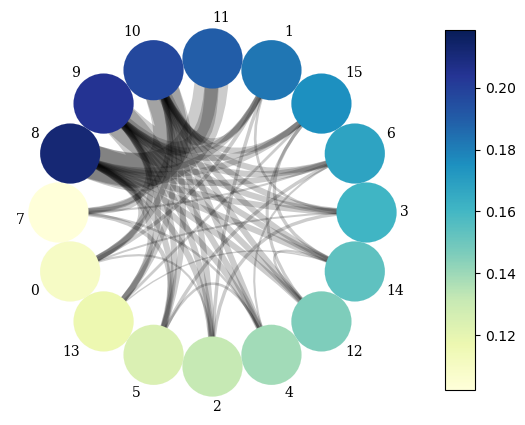

In [56]:
%autoreload
for demand_data, load in zip(demand_data_list, loads):
    plotter.plot_node_dist(eps=net.graph['endpoints'])

In [ ]:
print(demand.num_demands)
print(len(demand['flow_id']))

In [ ]:
_ = plotters.plot_link_loads_vs_time_for_different_loads(logscale=False)

In [ ]:
%autoreload
print('Keys of first demand data set:\n{}'.format(demand_data_list[0].keys()))
# print('\nStructure of first demand data set:\n{}'.format(demand_data_list[0]))

In [ ]:
%autoreload
for benchmark in benchmarks:
    print(benchmark_data[benchmark].keys())
    for load in list(benchmark_data[benchmark].keys()):
        for repeat in benchmark_data[benchmark][load]:
            print('benchmark: {} | load: {} | repeat: {}'.format(benchmark,load,repeat))

In [ ]:
%autoreload
from trafpy.generator import Demand
import sys
import json

demand = Demand(demand_data_list[-1])
for SLOT_SIZE in [1e4]:
    slots_dict = demand.get_slots_dict(SLOT_SIZE, print_info=True)

In [ ]:
slots_dict[0]